In [1]:
HOST = '37.139.42.145'
DBNAME = 'game-analytics'
USER = 'analytics'
PASSWORD = 'BRtTaqYiJyr29WXN'
from sqlalchemy import create_engine
engine = create_engine(f'postgresql://{USER}:{PASSWORD}@{HOST}/{DBNAME}')
import pandas as pd
group_schema='data_viz_1068'


In [2]:
installs=pd.read_sql(f'''
        SELECT  event_date, user_type,
        count(distinct user_id), region
        FROM data_viz_1068.project_dataset
        WHERE event_name='FirstLaunchApp' 
        GROUP BY 1,2,4
''', con=engine)

In [3]:
ret=pd.read_sql(f'''
         SELECT region, cast(second_sessions as float)/cast(first_sessions as float)*100 as per
         FROM
            (SELECT region,
            count(distinct user_id) as first_sessions,
            count(distinct user_id) filter(where user_id in
                                            (SELECT distinct user_id
                                             FROM data_viz_1068.project_dataset
                                             WHERE event_name='LaunchApp' and
                                             user_id in  ( SELECT user_id
                                                         FROM data_viz_1068.project_dataset
                                                         WHERE event_name='FirstLaunchApp'))) as second_sessions
            FROM data_viz_1068.project_dataset
            WHERE event_name='FirstLaunchApp' 
            GROUP BY 1) as a
            ORDER BY per DESC
        


''', con=engine)

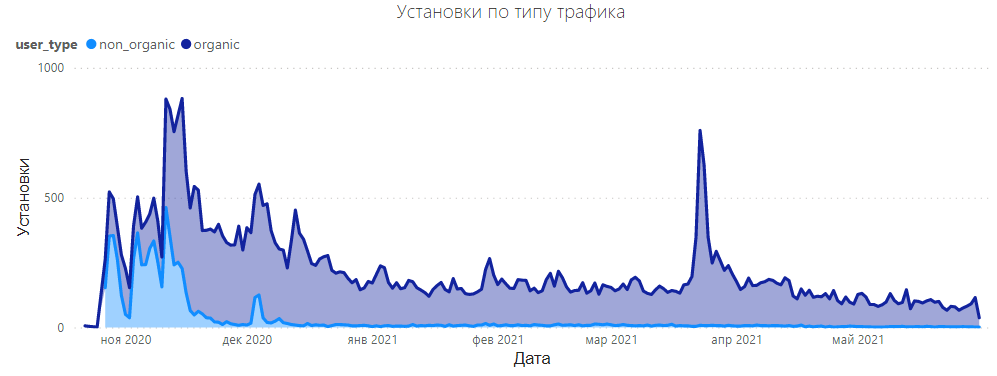

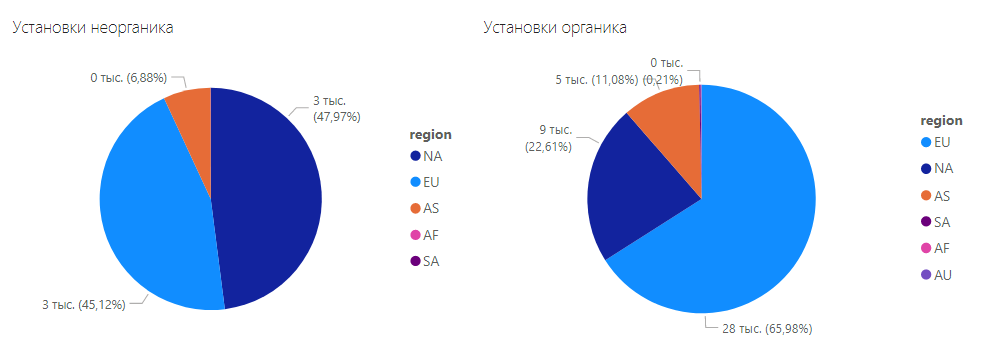

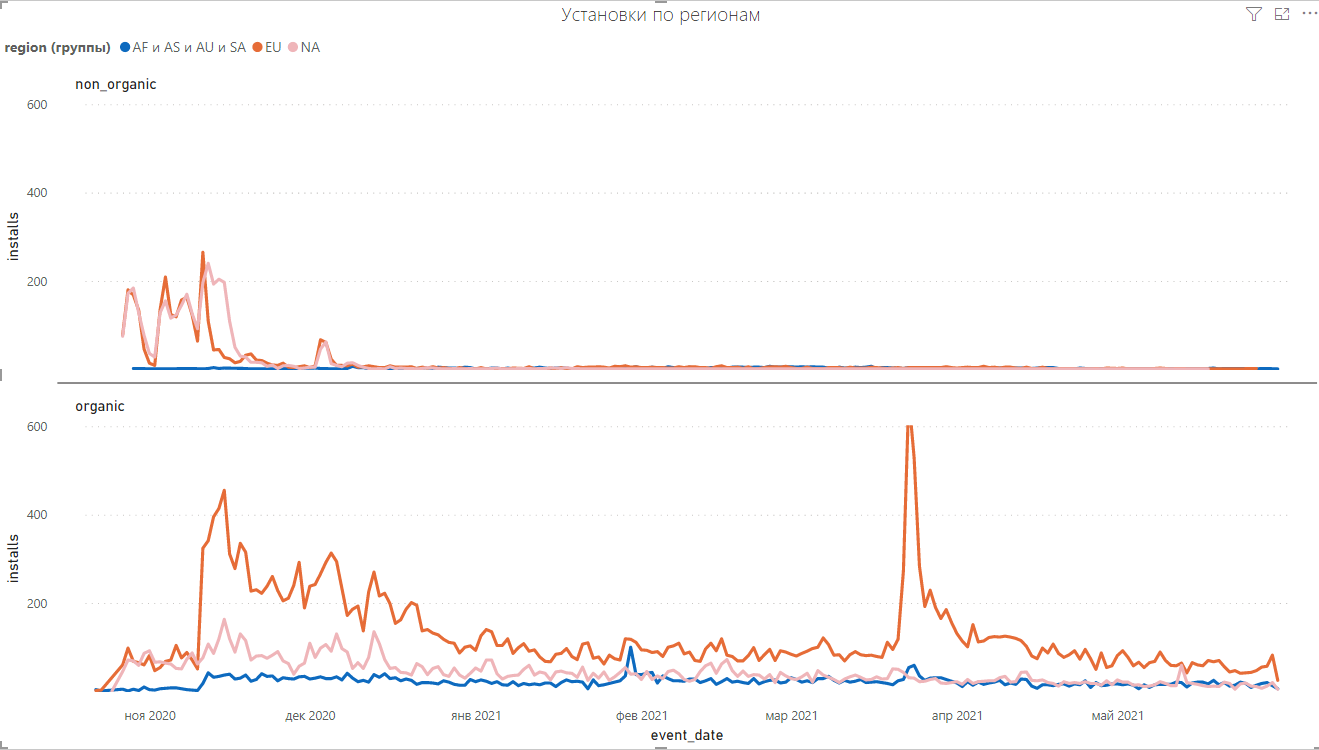

Проанализируйте динамику количества ежедневных инсталлов в игре для органики и неорганики. Какие особенности изменений этих показателей вы видите? Сгенерируйте гипотезы, почему могут наблюдаться такие изменения (которые затем в ходе выполнения дальнейших заданий вы сможете проверить).

    Вывод: Количество установок по обоим видам трафика с ноября по декабрь относительно одинаковое и находится в пределах 500 установок в день. После декабря установки по неограническому трафика начинают снижатся, данное поведение может быть вызвано сменой рекламных кампаний, либо меньшим их финансированием. Для органического трафика значения располагаются от 100 до 250-300 установок в день в среднем, допуская резкие повышения значений, которые могут быть связаны с ивентами в игре. Также, стоит отметить снижение числа установок и для органического трафика в конце графика. Возможно, это вызвано сезонностью.

Есть ли отличия этого показателя для разных регионов (СНГ, Европа, Азия, Северная Америка + Канада, Южная Америка)? Сделайте оценку в каких регионах более качественное удержание на начальном этапе (можно оценить, например, по второй сессии и проценту игроков, запустивших игру повторно).
        
      Вывод: Значения для регионов относительно сильно отличаются. Например,в AF,AS,AU,SA (вместе взятых) показатель по установкам стабильно в несколько раз меньше, чем в EU и NA по отдельности. Можно, заметить, что резкие перепады в росте установок вызваны изменениями в регионе EU и не касается других регионов. 
      Говоря о возврате игроков и их повторном запуске - наибольший процент повторного запуска зафиксирован в AU (83%), показатели в остальных регионах ниже. В EU, где число установок наиболее высокое процент повторного запуска игры ниже среднего.

In [4]:
ret

,region,per
0,AU,83.333333
1,NA,79.828096
2,AS,74.393723
3,EU,72.443488
4,AF,72.413793
5,SA,68.656716


In [5]:
installs=pd.read_sql(f'''
        SELECT event_name, count(event_name), user_type,region
        FROM(
        SELECT  event_time, user_type,event_name,user_id, region, min(event_time) filter (where event_name='FirstLaunchApp') OVER(PARTITION BY user_id) as date_install
        FROM data_viz_1068.project_dataset
        WHERE user_id in
                (SELECT user_id
                FROM data_viz_1068.project_dataset
                WHERE event_name='FirstLaunchApp')
        GROUP BY 1,2,3,4,5) as a
        WHERE event_time <=(date_install+INTERVAL '1' DAY) and event_name!='FirstLaunchApp'
        GROUP BY 1,3,4
''', con=engine)


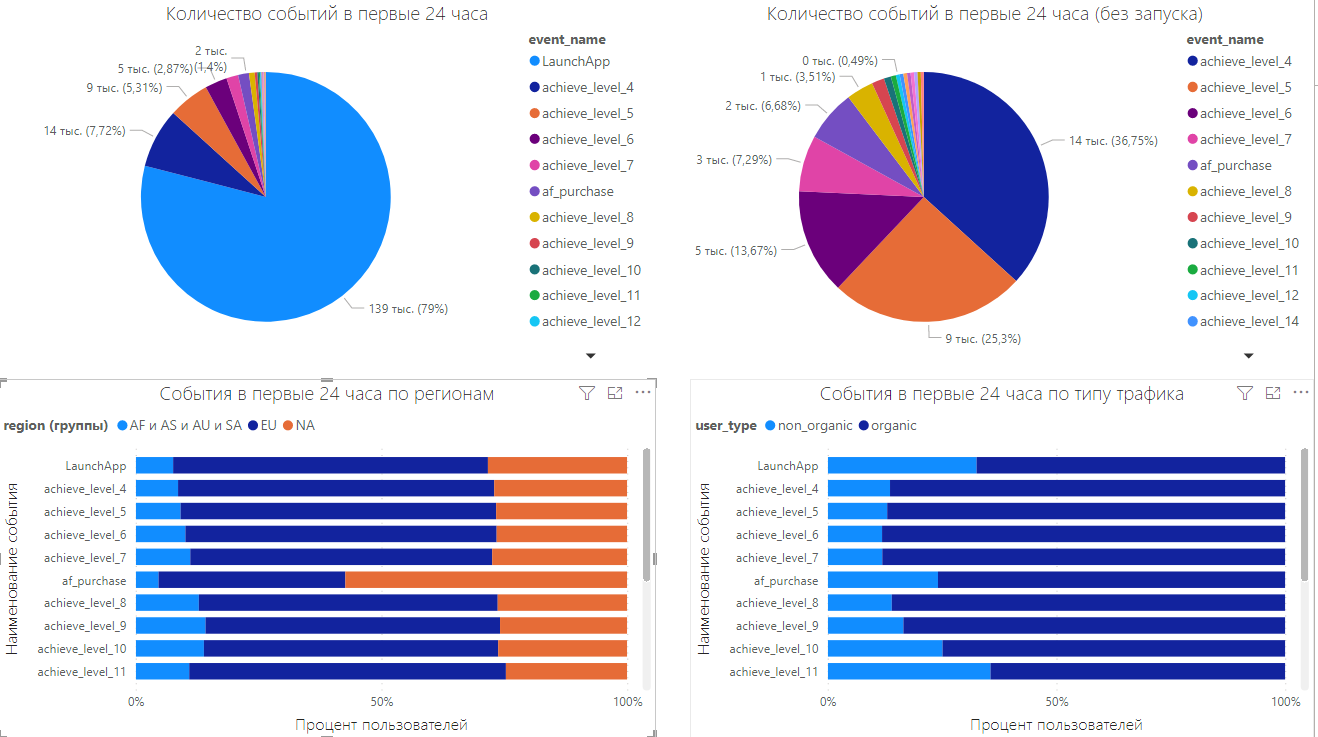

Проанализируйте поведение игроков в первые 24 часа после первого запуска игры. Какие события совершают пользователи чаще всего? Есть ли паттерны поведения игроков разных когорт (по типу пользователей, регионам и т.д.)?
    
    Вывод: В первые 24 часа после установки (первого запуска) большинство событий - запуск приложений повторно, поэтому рассмотрим 2 график. Чаще всего пользователи достигают 4 и 5 уровня (почти 50%), только 6,68% из событий после запуска относится к совершению платежа. Более высоких уровней за 24 часа достигают единицы. Говоря о зависимости по региону - платежи поступают чаще с региона NA, остальные события происходят примерно на одинаковом уровне, исходя из количества установок. Если же смотреть по типу трафика и учитывать, что установок намного больше у органического, то ситуация аналогичная. Платежей относительно много поступает с неорганического трафика, остальные события примерно в равном объеме (по процентому соотношению на число установок).